# Diabetes prediction

In this notebook I want to predict diabetes using some features from the following dataset from Kaggle:  
https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey
Here the whole working process will be displayed day by day.

#### 14.09.2019  
Whether the person has diabetes or not can be assessed  by measuring blood glycohemoglobin. The dataset above includes this lab examination. I will split survey participants into 3 categories using the following reference ranges:
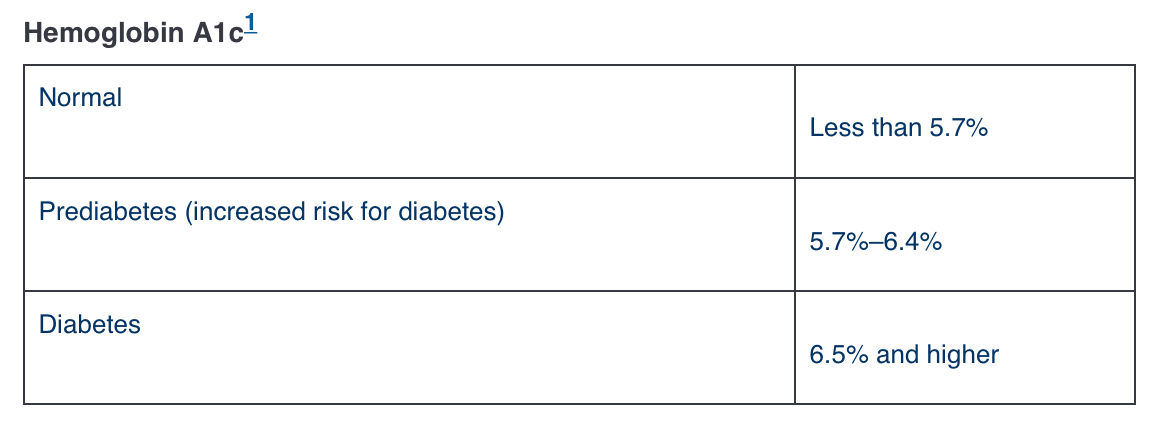
Source: https://www.uofmhealth.org/health-library/hw8432#hw8441


From the laboratory procedure manual https://wwwn.cdc.gov/nchs/data/nhanes/2013-2014/labmethods/GHB_H_MET_GLYCOHEMOGLOBIN.pdf
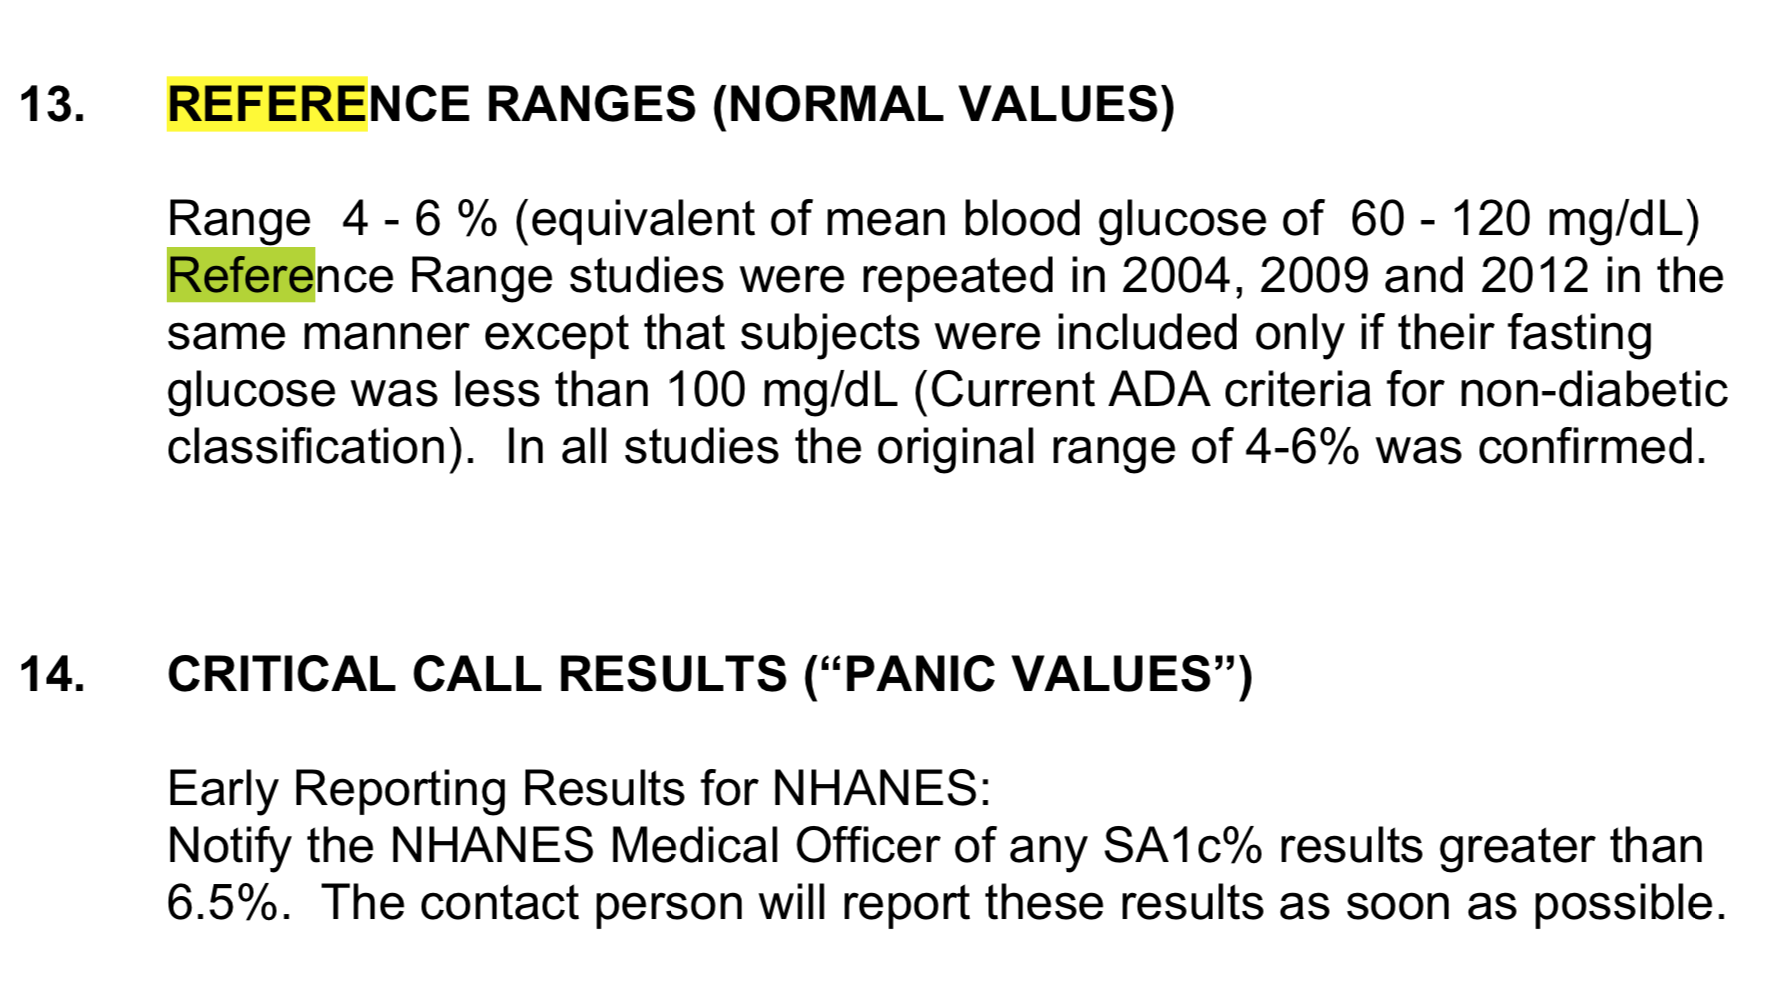

## Getting familiar with the dataset
#### 15.09.2019

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
%matplotlib inline

In [2]:
df1 = pd.read_csv("data/demographic.csv")

In [3]:
df1.shape

(10175, 47)

In [4]:
df1.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,3.0,4.0,NaN,13281.237386,13481.042095,1,112,4.0,4.0,0.84
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,4.0,1.0,3.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,3.0,1.0,4.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,5.0,1.0,5.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00


In [5]:
df2 = pd.read_csv("data/questionnaire.csv")

In [6]:
df2.shape

(10175, 953)

In [7]:
df3 = pd.read_csv("data/labs.csv")
df3.shape

(9813, 424)

In [8]:
df4 = pd.read_csv("data/examination.csv")
df4.shape

(9813, 224)

In [9]:
df = pd.merge(df1, df2, on='SEQN', how='inner')

In [10]:
df.shape

(10175, 999)

In [11]:
df = pd.merge(df,df3, on='SEQN', how='inner')

In [12]:
df.shape

(9813, 1422)

In [13]:
df = pd.merge(df,df4, on='SEQN', how='inner')

In [14]:
df.shape

(9813, 1645)

Plans:
1. Look at the general statistics of the dataset (like here https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8)
2. Select the relevant features and rename columns
3. Split the data into categories based on the glycohemoglobin levels, also check other tests like fasting glucose plasma and oral glucose tolerance test

## Some statistics of the whole dataset

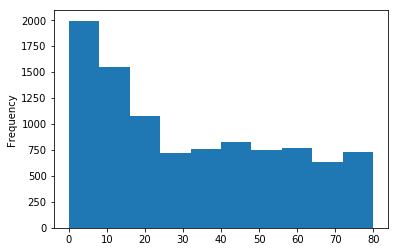

In [15]:
df["RIDAGEYR"].plot.hist()

Predict diabetes for people older than 25

In [16]:
df.drop(df.index[df['RIDAGEYR'] < 25], inplace = True)
df.shape

(5095, 1645)

Age is now uniformly distributed

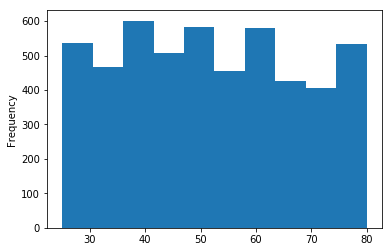

In [17]:
df["RIDAGEYR"].plot.hist()

Gender also looks balanced

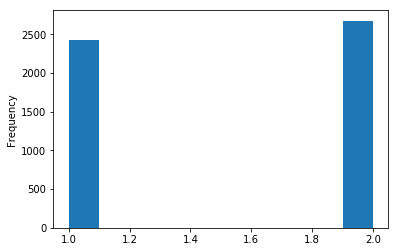

In [18]:
df["RIAGENDR"].plot.hist()

Glycohemoglobin histogram. We see that most of the respondents are in the "green" range of values (4-6%), but there are certainly some who show prediabetes or diabetes condition.

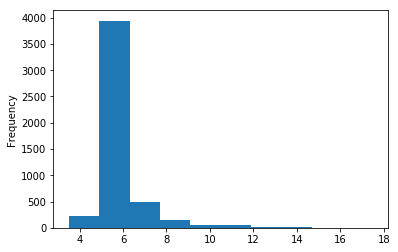

In [19]:
df["LBXGH"].plot.hist()

Unfortunately in the labs.csv there are no fasting glucose levels results even though they shold have been there according to the NHANES website under the code LBXGLU and LBDGLUSI. However two hours glucose tolerance test results are available. We will look at the histogram.

In [20]:
np.sum(df["LBXGH"].notna())

4920

We will exclude people from the analysis that don't have glycohemoglobin results.

In [21]:
df.drop(df.index[df['LBXGH'].isna()], inplace = True)
df.shape

(4920, 1645)

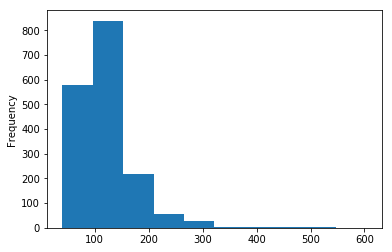

In [22]:
df["LBXGLT"].plot.hist()

Normally healthy people have the results lower than 140 mg/dL. A glucose level that is higher than normal may mean a person has pre-diabetes or diabetes:
- 2 hour value between 140 and 200 mg/dL (7.8 and 11.1 mmol/L) is called impaired glucose tolerance ("pre-diabetes").
- glucose level of 200 mg/dL (11.1 mmol/L) or higher is used to diagnose diabetes.



In [23]:
np.sum(df["LBXGLT"].notna())


1726

We see that this test was only performed for 1728 people so we will use the glycohemoglobin levels to split respondents into classes.

**Study description**  
Diabetes is a leading cause of disease and death in the United States. Approximately eight million Americans are known to have diabetes, and it is estimated that an equal amount have undiagnosed diabetes. In 1993, nearly 18 percent of all deaths for persons over the age of 25 were among people with diabetes. The prevalence of diabetes and overweight (one of the major risk factors for diabetes) continues to increase. Substantial new efforts to prevent or control diabetes have begun, including the Diabetes Prevention Trial and the National Diabetes Education Program.

Diabetes testing provides population data to: 1) determine a national estimate of diabetes disease prevalence (diagnosed and undiagnosed); 2) identify the risk factors of diabetes disease; 3) permit a national cohort to be established for follow-up studies of this condition; and 4) provide critical information to clinicians and public health officials for the development of preventive care and community-based interventions.

## Feature selection
#### 16.09.2019

Which features to take for the analysis?  

From demographics.csv table: 
- id SEQN
- age RIDAGEYR
- gender RIAGENDR
- educational level DMDEDUC2
- Annual family income INDFMIN2 
  
From questionnaire.csv table:
- Minutes sedentary activity PAD680
- Vigorous recreational activities PAQ650
- Minutes vigorous recreational activities PAD660
- Moderate recreational activities PAQ665
- Minutes moderate recreational activities PAD675
- Frequency of meals got from fast-food or pizza places DBD900
- Number of frozen meals/pizza in past 30 days DBD910
- Trouble sleeping or sleeping too much DPQ030
- Feeling tired or having little energy DPQ040  
- How do you consider your weight WHQ030

From examination.csv table:
- Body Mass Index (BMI) BMXBMI
- Waist Circumference (cm) BMXWAIST  

From labs.csv table:
- Blood manganese (umol/L) LBDBMNSI (reported to be a possible cause or feature of diabetes https://www.diabetes.co.uk/vitamins-supplements.html)

Feature to predict

In [24]:
# select multiple columns using loc
diabetes_feat = df.loc[:,['SEQN','RIDAGEYR', 'RIAGENDR', 'DMDEDUC2',
                          'INDFMIN2', 'PAD680', 'PAQ650', 'PAQ655', 
                          'PAD660','PAQ665','PAQ670','PAD675',
                          'DBD900', 'DBD910', 'DPQ030', 'DPQ040', 'WHQ030',
                          'BMXBMI', 'BMXWAIST', 'LBDBMNSI', 'LBXGH']]
diabetes_feat.shape

(4920, 21)

In [25]:
# rename columns properly

diabetes_feat.rename(columns={'SEQN':'id',
                              'RIDAGEYR':'age', 
                              'RIAGENDR':'gender', 
                              'DMDEDUC2':'edu_level',
                              'INDFMIN2':'fam_income',
                              'PAD680':'sedent_activ', 
                              'PAQ650':'vig_activ', 
                              'PAQ655':'days_vig_act',
                              'PAD660':'min_vig_activ',
                              'PAQ665':'moder_activ',
                              'PAQ670':'days_mod_act',
                              'PAD675':'min_mod_activ',
                              'DBD900':'fast_food_freq', 
                              'DBD910':'froz_meal_freq',
                              'DPQ030':'sleep_disorder', 
                              'DPQ040':'little_energy', 
                              'WHQ030':'self_estim_weight', 
                              'BMXBMI':'BMI', 
                              'BMXWAIST':'waist_circum', 
                              'LBDBMNSI':'bld_manganese',
                              'LBXGH':'glycohemoglobin'}, inplace=True)
diabetes_feat.head()

,id,age,gender,edu_level,fam_income,sedent_activ,vig_activ,days_vig_act,min_vig_activ,moder_activ,...,min_mod_activ,fast_food_freq,froz_meal_freq,sleep_disorder,little_energy,self_estim_weight,BMI,waist_circum,bld_manganese,glycohemoglobin
0,73557,69,1,3.0,4.0,600.0,2.0,NaN,NaN,2.0,...,NaN,8.0,4.0,0.0,0.0,3.0,26.7,100.0,NaN,13.9
1,73558,54,1,3.0,7.0,540.0,2.0,NaN,NaN,2.0,...,NaN,NaN,2.0,0.0,0.0,3.0,28.6,107.6,148.33,9.1
2,73559,72,1,4.0,10.0,300.0,2.0,NaN,NaN,1.0,...,180.0,0.0,0.0,0.0,0.0,3.0,28.9,109.2,174.17,8.9
4,73561,73,2,5.0,15.0,480.0,2.0,NaN,NaN,2.0,...,NaN,NaN,1.0,0.0,3.0,2.0,19.7,NaN,NaN,4.9
5,73562,56,1,4.0,9.0,360.0,2.0,NaN,NaN,2.0,...,NaN,14.0,0.0,3.0,3.0,1.0,41.7,123.1,254.62,5.5


In [26]:
diabetes_feat.loc[diabetes_feat['glycohemoglobin'] < 6.0, 'diabetes'] = 0
diabetes_feat.loc[(diabetes_feat['glycohemoglobin'] >=6.0) & (diabetes_feat['glycohemoglobin'] < 6.5), 'diabetes'] = 1
diabetes_feat.loc[diabetes_feat['glycohemoglobin'] >= 6.5, 'diabetes'] = 2

A method to assess physical activity of the person (to be improved).

In [27]:
def phys_activity(row):
   # if (row['vig_activ'] == 1 and row['days_vig_act'] >= 2.0) or (row['min_mod_activ'] >=60 and row['min_mod_activ'] >= 2.0):
   if (row['vig_activ'] == 1 and row['days_vig_act'] >= 2.0) or (row['min_mod_activ'] >= 30 and row['min_mod_activ'] >= 3.0):
        return 1
   return 2

diabetes_feat['phys_active'] = diabetes_feat.apply(lambda row: phys_activity(row), axis=1)

In [28]:
diabetes_feat.head()

,id,age,gender,edu_level,fam_income,sedent_activ,vig_activ,days_vig_act,min_vig_activ,moder_activ,...,froz_meal_freq,sleep_disorder,little_energy,self_estim_weight,BMI,waist_circum,bld_manganese,glycohemoglobin,diabetes,phys_active
0,73557,69,1,3.0,4.0,600.0,2.0,NaN,NaN,2.0,...,4.0,0.0,0.0,3.0,26.7,100.0,NaN,13.9,2.0,2
1,73558,54,1,3.0,7.0,540.0,2.0,NaN,NaN,2.0,...,2.0,0.0,0.0,3.0,28.6,107.6,148.33,9.1,2.0,2
2,73559,72,1,4.0,10.0,300.0,2.0,NaN,NaN,1.0,...,0.0,0.0,0.0,3.0,28.9,109.2,174.17,8.9,2.0,1
4,73561,73,2,5.0,15.0,480.0,2.0,NaN,NaN,2.0,...,1.0,0.0,3.0,2.0,19.7,NaN,NaN,4.9,0.0,2
5,73562,56,1,4.0,9.0,360.0,2.0,NaN,NaN,2.0,...,0.0,3.0,3.0,1.0,41.7,123.1,254.62,5.5,0.0,2


In [29]:
diabetes_feat.drop(['vig_activ', 'days_vig_act','min_vig_activ','moder_activ','days_mod_act','min_mod_activ','glycohemoglobin'], axis=1, inplace=True)

In [30]:
diabetes_feat.head()

,id,age,gender,edu_level,fam_income,sedent_activ,fast_food_freq,froz_meal_freq,sleep_disorder,little_energy,self_estim_weight,BMI,waist_circum,bld_manganese,diabetes,phys_active
0,73557,69,1,3.0,4.0,600.0,8.0,4.0,0.0,0.0,3.0,26.7,100.0,NaN,2.0,2
1,73558,54,1,3.0,7.0,540.0,NaN,2.0,0.0,0.0,3.0,28.6,107.6,148.33,2.0,2
2,73559,72,1,4.0,10.0,300.0,0.0,0.0,0.0,0.0,3.0,28.9,109.2,174.17,2.0,1
4,73561,73,2,5.0,15.0,480.0,NaN,1.0,0.0,3.0,2.0,19.7,NaN,NaN,0.0,2
5,73562,56,1,4.0,9.0,360.0,14.0,0.0,3.0,3.0,1.0,41.7,123.1,254.62,0.0,2


In [31]:
diabetes_feat.drop(diabetes_feat.index[diabetes_feat['fast_food_freq'].isna()], inplace=True)
diabetes_feat.drop(diabetes_feat.index[diabetes_feat['froz_meal_freq'].isna()], inplace=True)

In [32]:
diabetes_feat.drop(diabetes_feat.index[diabetes_feat['bld_manganese'].isna()], inplace=True)

In [33]:
diabetes_feat.drop(diabetes_feat.index[diabetes_feat['sleep_disorder'].isna()], inplace=True)

In [34]:
diabetes_feat.drop(diabetes_feat.index[diabetes_feat['little_energy'].isna()], inplace=True)

In [35]:
# all the above can be replaced by a single command below which deletes a row if any of the values is NaN
diabetes_feat.dropna(axis=0,how='any', inplace=True)

In [36]:
diabetes_feat.shape

(1628, 16)

In [37]:
diabetes_feat.head()

,id,age,gender,edu_level,fam_income,sedent_activ,fast_food_freq,froz_meal_freq,sleep_disorder,little_energy,self_estim_weight,BMI,waist_circum,bld_manganese,diabetes,phys_active
2,73559,72,1,4.0,10.0,300.0,0.0,0.0,0.0,0.0,3.0,28.9,109.2,174.17,2.0,1
5,73562,56,1,4.0,9.0,360.0,14.0,0.0,3.0,3.0,1.0,41.7,123.1,254.62,0.0,2
7,73564,61,2,5.0,10.0,60.0,1.0,0.0,0.0,1.0,1.0,35.7,110.8,305.76,0.0,2
21,73580,38,2,3.0,12.0,240.0,0.0,0.0,0.0,1.0,3.0,35.9,107.4,76.80,0.0,2
26,73585,28,1,4.0,7.0,480.0,0.0,2.0,0.0,0.0,3.0,30.1,90.3,164.35,0.0,1


To do for tomorrow:
1. Look at the statistics of the processed dataset, try to estimate which features could be important for diabetes prediction. Look for corellations.
2. Maybe make one single column from the two vigorous and moderate activity
2. Decide how to standardize and normalize the values in the table
3. Think about how to treat responses like 'don't know' or 'refused' (they can be present in each column)
4. Work on this article and see also in these dataset how manganese and BMI are varying among diabetic and nondiabetic people http://www.diabetesincontrol.com/estimating-concentrations-of-chromium-and-manganese-in-diabetes-patients/

In [38]:
np.sum(diabetes_feat['self_estim_weight'] == 9)

3

#### 17.09.2019
Worked on the method how to combine physical activity feature into one single

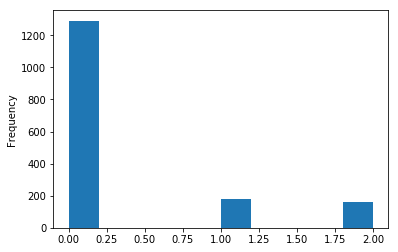

In [39]:
diabetes_feat['diabetes'].plot.hist()

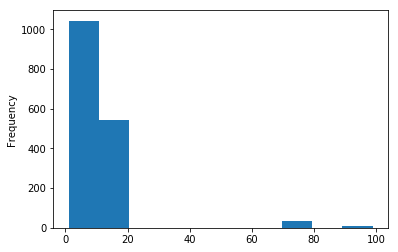

In [40]:
diabetes_feat['fam_income'].plot.hist()

Traces near 80 and 100 come from responses 'refused' and 'don't know'

## Value codes
We need to go through each feature column and understand value-codes befor we normalize and standardize the data:  
- **id** - unique identifier (will be excluded from the analysis)  
- **age** - normal age in years  
- **gender** - 1 stands for male, 2 for female  
- **edu_level**   
  
1	Less than 9th grade  
2	9-11th grade (Includes 12th grade with no diploma)  
3	High school graduate/GED or equivalent  
4	Some college or AA degree  
5	College graduate or above  
7	Refused  
9	Don't Know  
  
- annual **fam_income** in dollars  
  
1	0 to 4,999  
2	5,000 to 9,999  
3	10,000 to 14,999	
4	15,000 to 19,999	
5	20,000 to 24,999	
6	25,000 to 34,999	
7	35,000 to 44,999	
8	45,000 to 54,999	
9	55,000 to 64,999	
10	65,000 to 74,999	
12	20,000 and Over    
13	Under 20,000   
14	75,000 to 99,999	
15	100,000 and Over  
77	Refused  
99	Don't know  
*12 and 13 code values should be deleted maybe?*  
  
- **sedent_activ**  
  
Minutes sedentary activity per day.  
Range of values from 0 to 1200  
7777 Refused  
9999 Don't know  
- **fast_food_freq**  
  
Number of meals from fast food/pizza places per week  
Range of values from 0 to 21  
5555 more than 21  
7777  
9999
- **froz_meal_freq**
  
Number of frozen meals or pizzas in the past 30 days  
Range of values between 0 and 180  
7777  
9999  

- **sleep_disorder** (maybe would be better to take the average hours sleeping per night, this info is in the medical condition section)
  
Trouble sleeping or sleeping too much  
0	Not at all  
1	Several days  
2	More than half the days  
3	Nearly every day  
7	Refused  
9	Don't know  
  
- **little_energy** (maybe delete this)

0	Not at all  
1	Several days  
2	More than half the days  
3	Nearly every day  
7	Refused  
9	Don't know  

- **self_estim_weight**
  
How do you consider your weight  
1	Overweight  
2	Underweight  
3	About the right weight  
7	Refused  
9	Don't know  
  
- **BMI**
Body Mass Index is a simple calculation using a person's height and weight. The formula is BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared. A BMI of 25.0 or more is overweight, while the healthy range is 18.5 to 24.9. BMI applies to most adults 18-65 years. (https://www.diabetes.ca/managing-my-diabetes/tools---resources/body-mass-index-(bmi)-calculator)  
  
Range of Values 12.1 to 82.9	
  
- **waist_circum** in cm
Range of values 40.2 to 177.9

- **bld_manganese** (umol/L)
Range of values 31.85 to 999.54

#### 18.09.1991 

I have to delete all 'refused' and 'don't know' answers

In [41]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['edu_level'] >= 7) & (diabetes_feat['edu_level'] <= 9)], inplace=True)
diabetes_feat.shape

(1628, 16)

In [42]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['fam_income'] >= 77) & (diabetes_feat['fam_income'] <= 99)], inplace=True)
diabetes_feat.shape

(1585, 16)

In [43]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['sedent_activ'] >= 7777) & (diabetes_feat['sedent_activ'] <= 9999)], inplace=True)
diabetes_feat.shape

(1583, 16)

In [44]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['fast_food_freq'] >= 5555) & (diabetes_feat['fast_food_freq'] <= 9999)], inplace=True)
diabetes_feat.shape

(1582, 16)

In [45]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['froz_meal_freq'] >= 7777) & (diabetes_feat['froz_meal_freq'] <= 9999)], inplace=True)
diabetes_feat.shape

(1582, 16)

In [46]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['sleep_disorder'] >= 7) & (diabetes_feat['sleep_disorder'] <= 9)], inplace=True)
diabetes_feat.shape

(1581, 16)

In [47]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['little_energy'] >= 7) & (diabetes_feat['little_energy'] <= 9)], inplace=True)
diabetes_feat.shape

(1581, 16)

In [48]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['self_estim_weight'] >= 7) & (diabetes_feat['self_estim_weight'] <= 9)], inplace=True)
diabetes_feat.shape

(1579, 16)

Now I have to decide how to treat the annual income codes 12 and 13. The ones who answered 20 000 and over go into category 6 (20 000 to 25 000). The ones who answered 20 000 and lower go into category 4 (15 000 - 20 000).

In [49]:
np.sum(diabetes_feat["fam_income"] == 12)

36

In [50]:
np.sum(diabetes_feat["fam_income"] == 13)

7

In [51]:
diabetes_feat.loc[diabetes_feat['fam_income'] == 12, 'fam_income'] = 5
diabetes_feat.loc[diabetes_feat['fam_income'] == 13, 'fam_income'] = 4

In [52]:
# now categories 14 and 15 can take the values 12 and 13
diabetes_feat.loc[diabetes_feat['fam_income'] == 14, 'fam_income'] = 12
diabetes_feat.loc[diabetes_feat['fam_income'] == 15, 'fam_income'] = 13

In [53]:
print(diabetes_feat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1579 entries, 2 to 9805
Data columns (total 16 columns):
id                   1579 non-null int64
age                  1579 non-null int64
gender               1579 non-null int64
edu_level            1579 non-null float64
fam_income           1579 non-null float64
sedent_activ         1579 non-null float64
fast_food_freq       1579 non-null float64
froz_meal_freq       1579 non-null float64
sleep_disorder       1579 non-null float64
little_energy        1579 non-null float64
self_estim_weight    1579 non-null float64
BMI                  1579 non-null float64
waist_circum         1579 non-null float64
bld_manganese        1579 non-null float64
diabetes             1579 non-null float64
phys_active          1579 non-null int64
dtypes: float64(12), int64(4)
memory usage: 209.7 KB
None


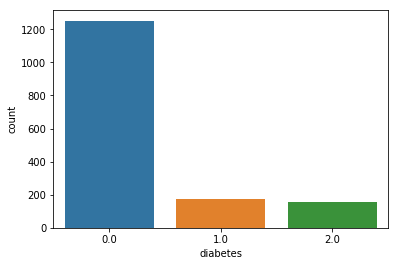

In [54]:
sns.countplot(diabetes_feat['diabetes'],label="Count")

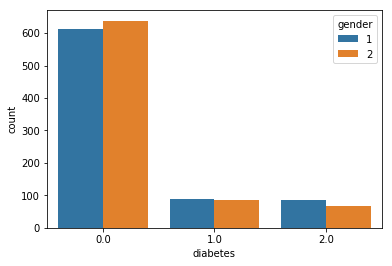

In [55]:
plt.figure()
sns.countplot(x='diabetes', hue='gender', data=diabetes_feat)

Gender seems to play no role in diabetes.

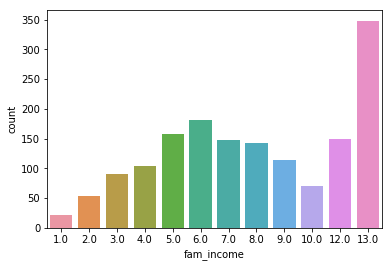

In [56]:
sns.countplot('fam_income', data=diabetes_feat)

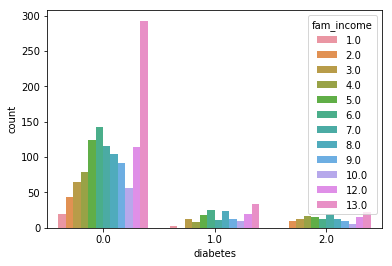

In [57]:
sns.countplot(x='diabetes', hue='fam_income', data=diabetes_feat)

Now I am interested to see how the frequency of diabetes changes with growing BMI. I am expecting that people with the BMI bigger than 25 will have pre-diabetes or diabetes more often.

/Users/elming/anaconda3/envs/dsmlai/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Side-by-Side Histogram')

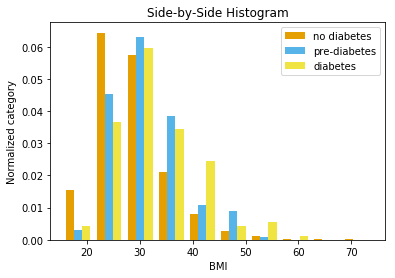

In [58]:
# Code adopted from https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
# Make a separate list for each diabetes category
x1 = list(diabetes_feat[diabetes_feat['diabetes'] == 0]['BMI'])
x2 = list(diabetes_feat[diabetes_feat['diabetes'] == 1]['BMI'])
x3 = list(diabetes_feat[diabetes_feat['diabetes'] == 2]['BMI'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442']
names = ['no diabetes', 'pre-diabetes', 'diabetes']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3], bins = 10, normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('BMI')
plt.ylabel('Normalized category')
plt.title('Side-by-Side Histogram')

Text(0.5, 1.0, 'Stacked Histogram')

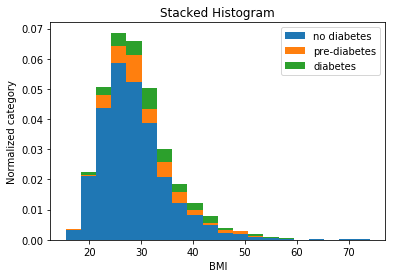

In [59]:
plt.hist([x1, x2, x3], bins = 20, stacked=True,
         normed=True, label=names)
plt.legend()
plt.xlabel('BMI')
plt.ylabel('Normalized category')
plt.title('Stacked Histogram')

As I see on the histograms my expectation was right, most diabetes labeled people have BMI above 25. Now we can perform the same plot based on the waist circumference that was reported to corellate with diabetes.

Text(0.5, 1.0, 'Side-by-Side Histogram')

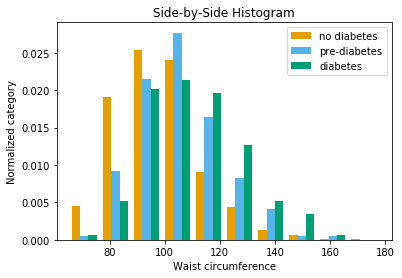

In [60]:
# Make a separate list for each diabetes category
x1 = list(diabetes_feat[diabetes_feat['diabetes'] == 0]['waist_circum'])
x2 = list(diabetes_feat[diabetes_feat['diabetes'] == 1]['waist_circum'])
x3 = list(diabetes_feat[diabetes_feat['diabetes'] == 2]['waist_circum'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#009E73']
names = ['no diabetes', 'pre-diabetes', 'diabetes']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3], bins = 10, normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Waist circumference')
plt.ylabel('Normalized category')
plt.title('Side-by-Side Histogram')

Same story: the distribution of the healthy people is skewed to the smaller values of the waist_circumference, the distribution of diabetic people or the ones at risk is skewed towards the larger values. Large weight and waist are consequences of bad diet.

Text(0.5, 1.0, 'Side-by-Side Histogram')

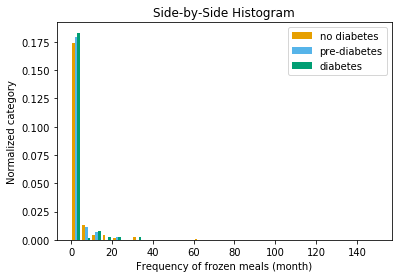

In [61]:
# Make a separate list for each diabetes category
x1 = list(diabetes_feat[diabetes_feat['diabetes'] == 0]['froz_meal_freq'])
x2 = list(diabetes_feat[diabetes_feat['diabetes'] == 1]['froz_meal_freq'])
x3 = list(diabetes_feat[diabetes_feat['diabetes'] == 2]['froz_meal_freq'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#009E73']
names = ['no diabetes', 'pre-diabetes', 'diabetes']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3], bins = 30, normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Frequency of frozen meals (month)')
plt.ylabel('Normalized category')
plt.title('Side-by-Side Histogram')

In [62]:
diabetes_feat.head()

,id,age,gender,edu_level,fam_income,sedent_activ,fast_food_freq,froz_meal_freq,sleep_disorder,little_energy,self_estim_weight,BMI,waist_circum,bld_manganese,diabetes,phys_active
2,73559,72,1,4.0,10.0,300.0,0.0,0.0,0.0,0.0,3.0,28.9,109.2,174.17,2.0,1
5,73562,56,1,4.0,9.0,360.0,14.0,0.0,3.0,3.0,1.0,41.7,123.1,254.62,0.0,2
7,73564,61,2,5.0,10.0,60.0,1.0,0.0,0.0,1.0,1.0,35.7,110.8,305.76,0.0,2
21,73580,38,2,3.0,5.0,240.0,0.0,0.0,0.0,1.0,3.0,35.9,107.4,76.80,0.0,2
26,73585,28,1,4.0,7.0,480.0,0.0,2.0,0.0,0.0,3.0,30.1,90.3,164.35,0.0,1


## Starting with predictions

### Select input features, output and split the data into train and test

In [63]:
diabetes_feat = diabetes_feat.drop(['id','gender','sleep_disorder', 'self_estim_weight'], axis=1)
diabetes_feat.head()

,age,edu_level,fam_income,sedent_activ,fast_food_freq,froz_meal_freq,little_energy,BMI,waist_circum,bld_manganese,diabetes,phys_active
2,72,4.0,10.0,300.0,0.0,0.0,0.0,28.9,109.2,174.17,2.0,1
5,56,4.0,9.0,360.0,14.0,0.0,3.0,41.7,123.1,254.62,0.0,2
7,61,5.0,10.0,60.0,1.0,0.0,1.0,35.7,110.8,305.76,0.0,2
21,38,3.0,5.0,240.0,0.0,0.0,1.0,35.9,107.4,76.80,0.0,2
26,28,4.0,7.0,480.0,0.0,2.0,0.0,30.1,90.3,164.35,0.0,1


In [64]:
diabetes_feat.shape

(1579, 12)

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes_feat.loc[:, diabetes_feat.columns != 'diabetes'], diabetes_feat['diabetes'], stratify=diabetes_feat['diabetes'], test_size=0.2, random_state=66)

In [66]:
len(X_train)

1263

In [67]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1263, 11) (316, 11) (1263,) (316,)


### Try out KNN Classifier

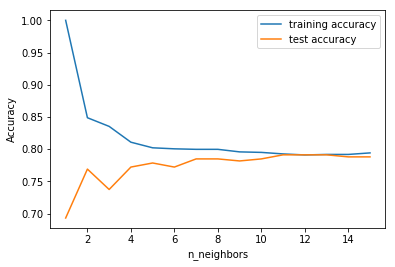

In [68]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 16)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

The plot suggests that we should choose n_neighbors=12. Here we are:

In [69]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.79


In [70]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = knn.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[249,   1,   0],
       [ 34,   1,   0],
       [ 31,   0,   0]])

To do for tomorrow:
1. Go on with other algorithms and look how they perform
2. Look which features help in predicting the most

#### 20.09.2019

## Decision tree

In [71]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=0)
dec_tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(dec_tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dec_tree.score(X_test, y_test)))

Accuracy on training set: 0.796
Accuracy on test set: 0.794


In [72]:
print("Feature importances:\n{}".format(dec_tree.feature_importances_))

Feature importances:
[0.65555084 0.         0.         0.         0.0780845  0.
 0.         0.07964036 0.1867243  0.         0.        ]


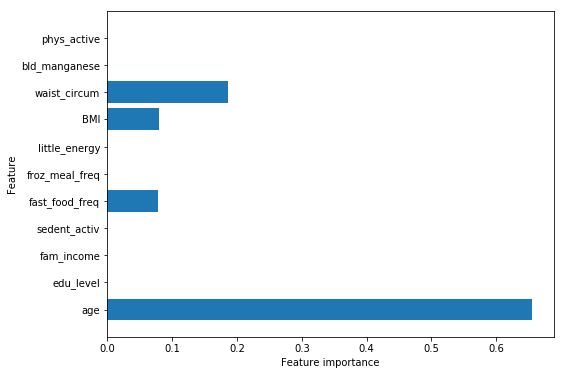

In [73]:
diabetes_features = [x for i,x in enumerate(X_train.columns)]
def plot_feature_importances_diabetes(model):
    plt.figure(figsize=(8,6))
    n_features = 11
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), diabetes_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_diabetes(dec_tree)
plt.savefig('feature_importance')

In [74]:
labels = ['no diabetes', 'pre-diabetes', 'diabetes']

# Export as dot file
export_graphviz(dec_tree, out_file='dec_tree.dot', 
                feature_names = X_train.columns,
                class_names = labels,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'dec_tree.dot', '-o', 'dec_tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'dec_tree.png')

NameError: name 'export_graphviz' is not defined

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

In [ ]:
plot_feature_importances_diabetes(rf)

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

In [ ]:
labels = ['no diabetes', 'pre-diabetes', 'diabetes']
estimator = rf.estimators_[20]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = labels,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


In [ ]:
y_pred = rf.predict(X_test)
confusion_matrix(y_true, y_pred)

## Support vector machine

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Sometimes scaling helps to achieve better results

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
svc = SVC(C=1, kernel='rbf', gamma=50)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

In [ ]:
y_pred = svc.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

## Deep Learning

In [75]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(49,), max_iter=50)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.794
Accuracy on test set: 0.794


/Users/elming/anaconda3/envs/dsmlai/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [79]:
y_pred = mlp.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[249,   1,   0],
       [ 34,   0,   1],
       [ 29,   0,   2]])

To do:
1. Look at different accuracy score, try ROC curve
2. Work further on Random forests, try less features
3. Try to balance the dataset

In [83]:
from sklearn.metrics import f1_score
f1_score(y_true,y_pred, average='weighted')

0.7125864175121827